In [1]:
import gc
import torch
from typing import List, TypedDict
from pprint import pprint

from pydantic import BaseModel, Field
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter, HTMLHeaderTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})

urls = [
    "https://google.github.io/styleguide/pyguide.html",
    "https://google.github.io/styleguide/javaguide.html",
    "https://google.github.io/styleguide/jsguide.html"
]

headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
    ("h3", "Header 3"),
]
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
html_header_splits = []
for url in urls:
    splits = html_splitter.split_text_from_url(url)
    html_header_splits.extend(splits)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(html_header_splits)

In [3]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name='rag-chroma',
    embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
for chunk in doc_splits[:3]: # 앞부분 3개만 확인
    print(f"Content Preview: {chunk.page_content[:50]}...")
    print(f"Metadata: {chunk.metadata}") 
    print("-" * 20)

Content Preview: AUTHORS:
Prefer only GitHub-flavored Markdown in e...
Metadata: {}
--------------------
Content Preview: Google Python Style Guide...
Metadata: {'Header 1': 'Google Python Style Guide'}
--------------------
Content Preview: Table of Contents  
1 Background  
2 Python Langua...
Metadata: {'Header 1': 'Google Python Style Guide'}
--------------------


In [6]:
class GradeDocuments(BaseModel):
    binary_score: str = Field(description='문서와 질문의 연관성 여부를 "yes" 또는 "no"로 알려주세요.')

llm_eval = ChatOpenAI(model='gpt-5-nano', temperature=0)
structured_llm_grader = llm_eval.with_structured_output(GradeDocuments)

system = '''
당신은 사용자의 질문에 대해 검색된 문서의 관련성을 평가하는 전문가입니다.
문서에 질문과 관련된 키워드나 의미가 담겨 있으면, 해당 문서를 "관련 있음"으로 평가하세요.
문서가 질문과 관련이 있는지 여부를 "yes" 또는 "no"로 표시해주세요.'''

grade_prompt = ChatPromptTemplate.from_messages(
    [('system', system), ('human', '검색된 문서: \n\n {document} \n\n 사용자 질문: {question}')]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [7]:
question = '파이썬 코드 작성 가이드'

test = retriever.invoke(question)
test_txt = test[0].page_content
print(retrieval_grader.invoke({'question':question, 'document':test_txt}))

binary_score='yes'


In [8]:
llm_gen = ChatOpenAI(model='gpt-4o-mini', temperature=0)
system = '''
당신은 질문에 답변하는 업무를 돕는 도우미입니다.
제공된 문맥을 바탕으로 질문에 답변하세요. 만약 답을 모른다면 모른다고 말하세요.
세 문장을 넘지 않도록 답변을 간결하게 작성하세요.
'''
prompt = ChatPromptTemplate.from_messages(
    [('system', system), ('human', '질문: {question} \n문맥: {context} \n답변: ')]
)

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

rag_chain = prompt | llm_gen | StrOutputParser()

In [9]:
generation = rag_chain.invoke(
    {'context':format_docs(doc_splits), 'question':question}
)
print(generation)

파이썬 코드 작성 가이드는 Google Python Style Guide를 기반으로 하며, 코드의 가독성과 일관성을 높이기 위한 규칙들을 포함하고 있습니다. 주요 내용으로는 코드 포맷팅, 주석 및 문서화, 예외 처리, 함수 및 클래스 정의, 타입 주석 등이 있습니다. 각 항목은 명확한 규칙과 예시를 통해 설명되어 있어, 개발자들이 쉽게 따라할 수 있도록 돕습니다.


In [10]:
system = '''
당신은 입력된 질문을 변형하여 웹 검색에 최적화된 형태로 만드는 질문 생성기입니다.
입력된 질문을 보고 그 이면에 있는 의미나 의도를 파악해주세요.
'''
rewrite_prompt = ChatPromptTemplate(
    [('system', system), ('human', '질문: \n\n {question} \n 더 나은 질문으로 바꿔주세요. 단 최적의 질문 하나만 골라서 출력해주세요.')]
)

question_rewriter = rewrite_prompt | llm_eval | StrOutputParser()

In [11]:
question = 'C++ 깔끔하게 짜고 싶다.'
question_rewriter.invoke({'question':question})

'C++에서 가독성과 유지보수성을 높이는 코드 작성 방법은 무엇인가요?'

In [12]:
search_tool = TavilySearch(k=3)

In [13]:
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [14]:
def retrieve(state):
    print('---retrieve---')
    
    question = state['question']
    documents = retriever.invoke(question)

    return {'question':question, 'documents':documents}

In [15]:
def generate(state):
    print('---generate---')

    question = state['question']
    documents = state['documents']

    generation = rag_chain.invoke({'context':documents, 'question':question})

    return {'question':question, 'documents':documents, 'generation':generation}

In [16]:
def grade_documents(state):
    print('---grade documents---')

    question = state['question']
    documents = state['documents']

    filtered_docs = []
    web_search = 'no'
    for doc in documents:
        score = retrieval_grader.invoke(
            {'question':question, 'document':doc.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print('--relavant document--')
            filtered_docs.append(doc)
        else:
            print('--irrelavant document--')
            web_search = 'yes'
            continue
    
    return {'question':question, 'documents':filtered_docs, 'web_search':web_search}

In [17]:
def transform_query(state):
    print('---transform query---')

    question = state['question']
    documents = state['documents']

    better_question = question_rewriter.invoke({'question':question})

    return {'question':better_question, 'documents':documents}

In [18]:
def web_search(state):
    print('---web search---')

    question = state['question']
    documents = state['documents']

    docs = search_tool.invoke({'query':question})
    web_results = '\n'.join(doc['content'] for doc in docs)
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {'question':question, 'documents':documents}

In [19]:
def decide_to_generate(state):
    print('---decide to generate---')

    web_search = state['web_search']
    if web_search == 'yes':
        print('there is no relavant document. transform query')
        return 'transform_query'
    else:
        print('there is a relavant document. generate')
        return 'generate'

In [20]:
workflow = StateGraph(GraphState)

workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)
workflow.add_node('web_search', web_search)

workflow.set_entry_point('retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {'transform_query':'transform_query', 'generate':'generate'}
)
workflow.add_edge('transform_query', 'web_search')
workflow.add_edge('web_search', 'generate')
workflow.add_edge('generate', END)

app = workflow.compile()

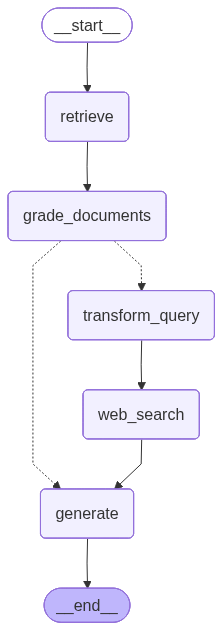

In [21]:
app

In [22]:
inputs = {'question':'구글의 코드 작성 가이드'}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f'Node "{key}":')

pprint(value['generation'])

---retrieve---
'Node "retrieve":'
---grade documents---
--relavant document--
--relavant document--
--relavant document--
--relavant document--
---decide to generate---
there is a relavant document. generate
'Node "grade_documents":'
---generate---
'Node "generate":'
('구글의 코드 작성 가이드는 JavaScript, Python, Java 등 여러 언어에 대한 스타일 가이드를 제공합니다. 현재 '
 'JavaScript 스타일 가이드는 더 이상 업데이트되지 않으며, 구글은 TypeScript로의 전환을 권장합니다. TypeScript '
 '가이드를 따르는 것이 좋습니다.')


In [23]:
inputs = {'question':'C++ 깔끔하게 짜고 싶다.'}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f'Node "{key}":')

pprint(value['generation'])

---retrieve---
'Node "retrieve":'
---grade documents---
--relavant document--
--relavant document--
--relavant document--
--relavant document--
---decide to generate---
there is a relavant document. generate
'Node "grade_documents":'
---generate---
'Node "generate":'
('C++ 코드를 깔끔하게 작성하려면 다음과 같은 스타일 가이드를 따르세요: 각 문장은 한 줄에 작성하고, 적절한 공백을 사용하여 가독성을 '
 '높입니다. 또한, 일관된 들여쓰기를 유지하고, 주석을 통해 코드의 의도를 명확히 하세요.')
